In [2]:
!pip install torchsummary

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
from torchsummary import summary

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

noisy_imgs_1 , noisy_imgs_2 = torch.load("/content/drive/MyDrive/deep_learning_epfl/train_data.pkl", map_location = device)
noisy_imgs_1 = (noisy_imgs_1  / 255.0).float()
noisy_imgs_2 = (noisy_imgs_2  / 255.0).float()

noisy_imgs_test, clean_images = torch.load("/content/drive/MyDrive/deep_learning_epfl/val_data.pkl", map_location = device)
noisy_imgs_test = (noisy_imgs_test / 255.0).float()
clean_images = (clean_images / 255.0).float()


cuda


# Normal Denoising Autoencoder

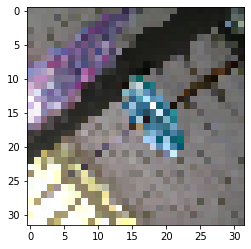

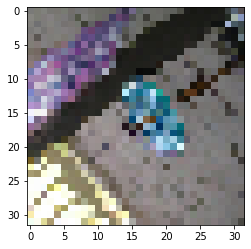

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 24, 24]          51,264
       BatchNorm2d-4           [-1, 64, 24, 24]             128
              ReLU-5           [-1, 64, 24, 24]               0
            Conv2d-6           [-1, 64, 11, 11]          65,600
              ReLU-7           [-1, 64, 11, 11]               0
            Conv2d-8             [-1, 64, 8, 8]          65,600
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 32, 5, 5]          32,800
  ConvTranspose2d-12             [-1, 64, 8, 8]          32,832
             ReLU-13             [-1, 64, 8, 8]               0
  ConvTranspose2d-14           [-1, 64,

In [6]:
plt.imshow(noisy_imgs_1[0].cpu().T)  # 3,32,32 to 32,32,3, .cpu() to bring them from the gpu
plt.show()  # display itnoisy_imgs_1[0])

plt.imshow(noisy_imgs_2[0].cpu().T) 
plt.show()  # display itnoisy_imgs_1[0])


class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
         nn.Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1)),
         nn.ReLU(inplace = True),
         nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1)),
         nn.BatchNorm2d(64),
         nn.ReLU (inplace = True),
         nn.Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2)),
         nn.ReLU(inplace=True),
         nn.Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1)),
         nn.BatchNorm2d(64),
         nn.ReLU(inplace=True),
         nn.Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1)),
      )
        
        
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(1, 1)),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1)),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1,1)),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(1, 1)),
        )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
summary(model, (3, 32, 32)) 

In [7]:
# training

nb_epochs = 20
mini_batch_size = 100
start = time.time()

for e in range(nb_epochs):
    train_loss = []
    for b in range(0, noisy_imgs_1.size(0), mini_batch_size):
        output = model(noisy_imgs_1.narrow(0, b, mini_batch_size))
        loss = criterion(output, noisy_imgs_2.narrow(0, b, mini_batch_size))
        train_loss.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch", e + 1, "Train loss:", np.mean(train_loss))

    # Test the model
    with torch.no_grad():
      test_results = model(noisy_imgs_test)
      print("Test loss: ", criterion(test_results, clean_images).cpu().numpy())
      print("---")


end = time.time()
print((end - start) / 60.0) # prints how long training took, in minutes

Epoch 1 Train loss: 0.11157737
Test loss:  0.034728207
---
Epoch 2 Train loss: 0.036432773
Test loss:  0.019212812
---
Epoch 3 Train loss: 0.02867452
Test loss:  0.0147624845
---
Epoch 4 Train loss: 0.025661057
Test loss:  0.012933513
---
Epoch 5 Train loss: 0.024097493
Test loss:  0.011559094
---
Epoch 6 Train loss: 0.022890124
Test loss:  0.010598138
---
Epoch 7 Train loss: 0.022104686
Test loss:  0.010131069
---
Epoch 8 Train loss: 0.021514053
Test loss:  0.00953327
---
Epoch 9 Train loss: 0.021030271
Test loss:  0.009032508
---
Epoch 10 Train loss: 0.020622857
Test loss:  0.008635616
---
Epoch 11 Train loss: 0.02026017
Test loss:  0.008316245
---
Epoch 12 Train loss: 0.019961717
Test loss:  0.008060927
---
Epoch 13 Train loss: 0.01971154
Test loss:  0.007863987
---
Epoch 14 Train loss: 0.019501586
Test loss:  0.0077261454
---
Epoch 15 Train loss: 0.019322021
Test loss:  0.0076036556
---
Epoch 16 Train loss: 0.01914412
Test loss:  0.0074544707
---
Epoch 17 Train loss: 0.018988892
Te

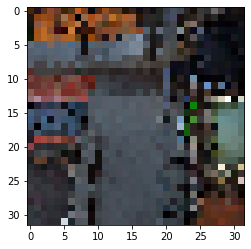

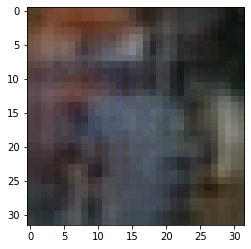

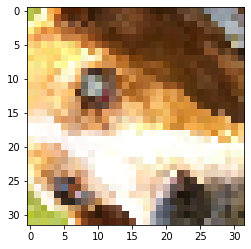

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


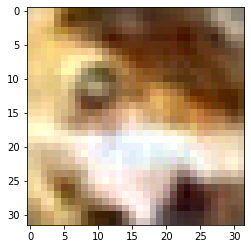

In [8]:
# Checking the results on the train set
imgs = noisy_imgs_1.narrow(0, 16, mini_batch_size)
imgs2 = noisy_imgs_2.narrow(0, 16, mini_batch_size)

results = model(imgs).cpu().detach().numpy()


for i in range(2):
  plt.imshow(imgs[i].cpu().T)
  plt.show()

  plt.imshow(results[i].T)
  plt.show()



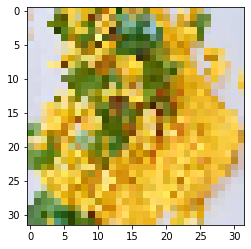

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


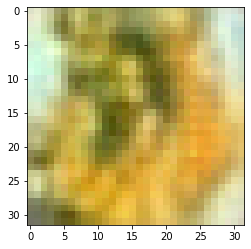

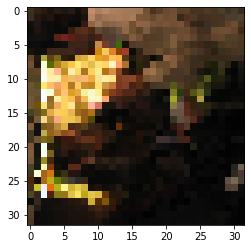

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


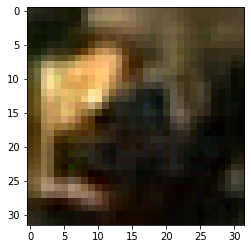

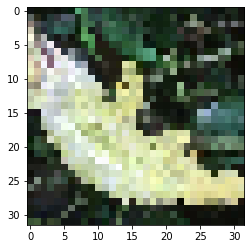

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


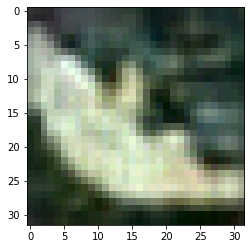

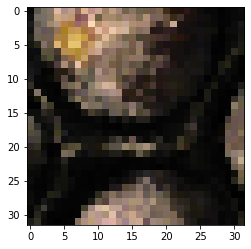

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


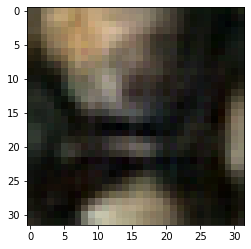

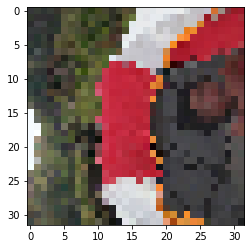

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


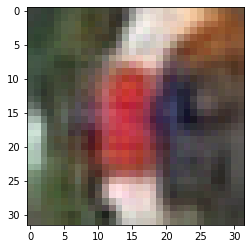

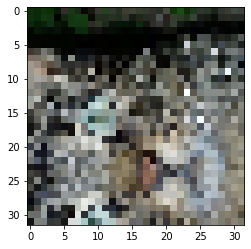

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


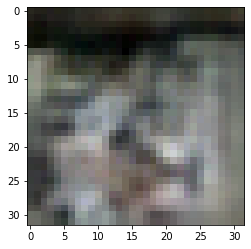

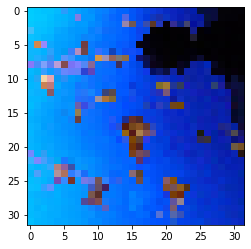

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


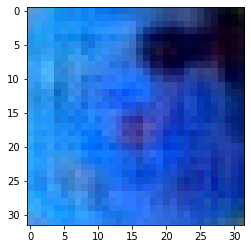

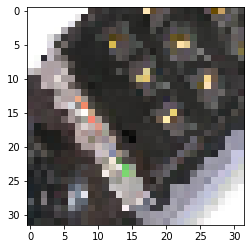

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


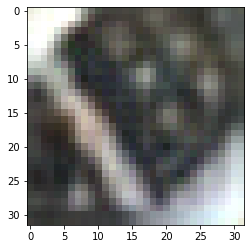

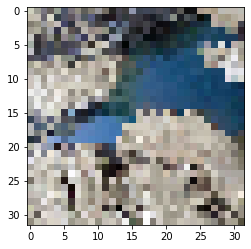

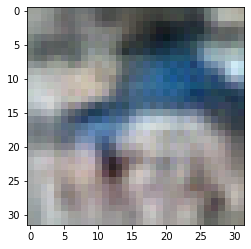

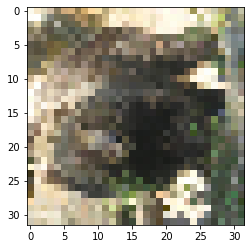

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


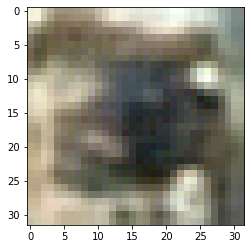

In [9]:
# Checking the results on the test set

imgs = noisy_imgs_test.narrow(0, 16, mini_batch_size)
imgs2 = clean_images.narrow(0, 16, mini_batch_size)

results = model(imgs).cpu().detach().numpy()


for i in range(10):
  plt.imshow(imgs[i].cpu().T)
  plt.show()

  plt.imshow(results[i].T)
  plt.show()

In [10]:
def psnr( denoised , ground_truth ) :
  # Peak Signal to Noise Ratio : denoised and ground˙truth have range [0 , 1]
  mse = torch.mean(( denoised - ground_truth ) ** 2)
  return -10 * torch.log10( mse + 10**-8)


results = model(noisy_imgs_test)

print(psnr(results, clean_images))

tensor(21.5333, device='cuda:0', grad_fn=<MulBackward0>)


# UNet

In [11]:
import torch
from torch import nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out


model = UNet(3,3,4, padding = True).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
     UNetConvBlock-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
    UNetConvBlock-10          [-1, 128, 16, 16]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [12]:
nb_epochs = 10
mini_batch_size = 100
start = time.time()

for e in range(nb_epochs):
    train_loss = []
    for b in range(0, noisy_imgs_1.size(0), mini_batch_size):
        output = model(noisy_imgs_1.narrow(0, b, mini_batch_size))
        loss = criterion(output, noisy_imgs_2.narrow(0, b, mini_batch_size))
        train_loss.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch", e + 1, "Train loss:", np.mean(train_loss))

    # Test the model
    with torch.no_grad():
      test_results = model(noisy_imgs_test)
      print("Test loss: ", criterion(test_results, clean_images).cpu().numpy())
      print("---")


end = time.time()
print((end - start) / 60.0)

Epoch 1 Train loss: 0.020137481
Test loss:  0.004017919
---
Epoch 2 Train loss: 0.014846569
Test loss:  0.0038171792
---
Epoch 3 Train loss: 0.014702091
Test loss:  0.0037774
---
Epoch 4 Train loss: 0.014632282
Test loss:  0.003702726
---
Epoch 5 Train loss: 0.0145786265
Test loss:  0.003634112
---
Epoch 6 Train loss: 0.014538974
Test loss:  0.0036111358
---
Epoch 7 Train loss: 0.014508311
Test loss:  0.0036352281
---


KeyboardInterrupt: ignored

In [16]:
def psnr( denoised , ground_truth ) :
  # Peak Signal to Noise Ratio : denoised and ground˙truth have range [0 , 1]
  mse = torch.mean(( denoised - ground_truth ) ** 2)
  return -10 * torch.log10( mse + 10**-8)


results = model(noisy_imgs_test)

print(psnr(results, clean_images))

tensor(21.3545, device='cuda:0', grad_fn=<MulBackward0>)


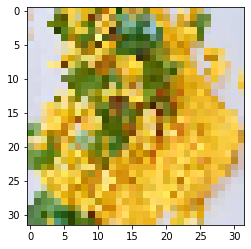

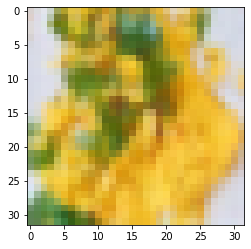

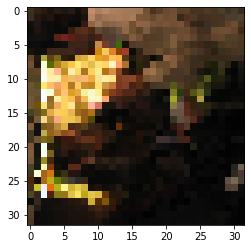

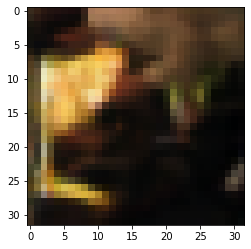

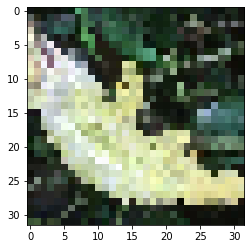

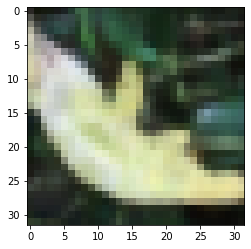

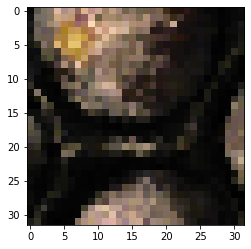

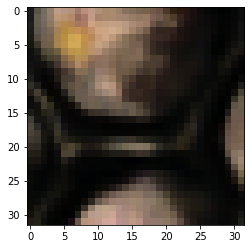

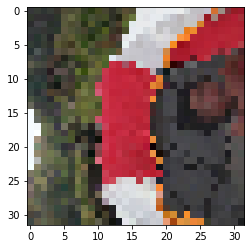

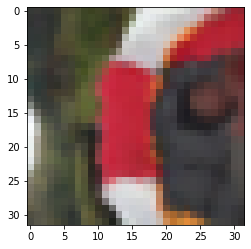

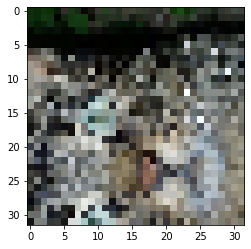

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


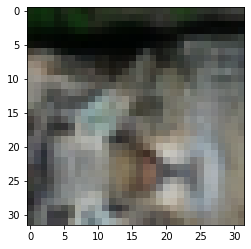

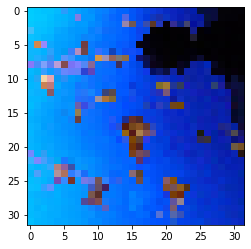

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


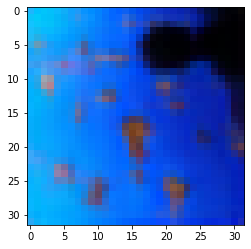

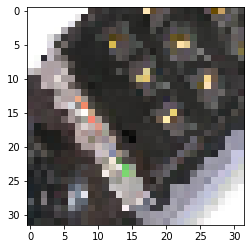

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


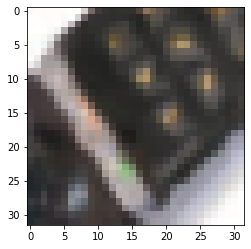

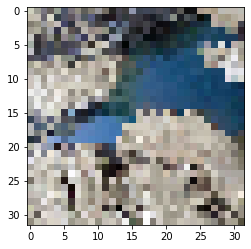

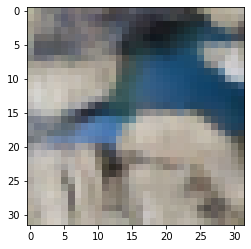

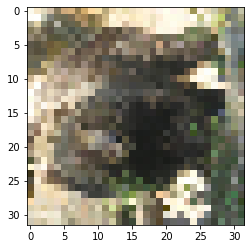

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


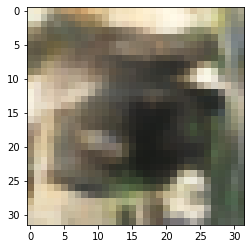

In [13]:
imgs = noisy_imgs_test.narrow(0, 16, mini_batch_size)
imgs2 = clean_images.narrow(0, 16, mini_batch_size)

results = model(imgs).cpu().detach().numpy()


for i in range(10):
  plt.imshow(imgs[i].cpu().T)
  plt.show()

  plt.imshow(results[i].T)
  plt.show()

# ResNet

In [14]:
# https://github.com/rishikksh20/ResUnet

class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class ResUnet(nn.Module):
    def __init__(self, channel, filters=[8, 16, 32, 64]):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.bridge = ResidualConv(filters[2], filters[3], 2, 1)

        self.upsample_1 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_2 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_3 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 3, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        # Bridge
        x4 = self.bridge(x3)
        # Decode
        x4 = self.upsample_1(x4)
        x5 = torch.cat([x4, x3], dim=1)

        x6 = self.up_residual_conv1(x5)

        x6 = self.upsample_2(x6)
        x7 = torch.cat([x6, x2], dim=1)

        x8 = self.up_residual_conv2(x7)

        x8 = self.upsample_3(x8)
        x9 = torch.cat([x8, x1], dim=1)

        x10 = self.up_residual_conv3(x9)

        output = self.output_layer(x10)

        return output


model = ResUnet(3).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
summary(model, (3, 32, 32))

img = torch.ones(1, 3, 32, 32).to(device)
resunet = ResUnet(3).to(device)
print(resunet(img).size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
            Conv2d-4            [-1, 8, 32, 32]             584
            Conv2d-5            [-1, 8, 32, 32]             224
       BatchNorm2d-6            [-1, 8, 32, 32]              16
              ReLU-7            [-1, 8, 32, 32]               0
            Conv2d-8           [-1, 16, 16, 16]           1,168
       BatchNorm2d-9           [-1, 16, 16, 16]              32
             ReLU-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           2,320
           Conv2d-12           [-1, 16, 16, 16]           1,168
      BatchNorm2d-13           [-1, 16, 16, 16]              32
     ResidualConv-14           [-1, 16,

In [17]:
nb_epochs = 10
mini_batch_size = 100
start = time.time()


for e in range(nb_epochs):
    train_loss = []
    for b in range(0, noisy_imgs_1.size(0), mini_batch_size):
        output = model(noisy_imgs_1.narrow(0, b, mini_batch_size))
        loss = criterion(output, noisy_imgs_2.narrow(0, b, mini_batch_size))
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch", e + 1, "Train loss:", np.mean(train_loss))

    # Test the model
    with torch.no_grad():
      test_results = model(noisy_imgs_test)
      print("Test loss: ", criterion(test_results, clean_images).cpu().numpy())
      print("---")


end = time.time()
print((end - start) / 60.0)

Epoch 1 Train loss: 0.016164058810099958
Test loss:  0.0045074737
---
Epoch 2 Train loss: 0.015472327791154384
Test loss:  0.004243543
---
Epoch 3 Train loss: 0.015286390878260135
Test loss:  0.0041013043
---
Epoch 4 Train loss: 0.01516069701872766
Test loss:  0.003977485
---
Epoch 5 Train loss: 0.015054683025926352
Test loss:  0.0038824717
---
Epoch 6 Train loss: 0.014975665306672454
Test loss:  0.0038192351
---
Epoch 7 Train loss: 0.014913655897602438
Test loss:  0.0037766767
---
Epoch 8 Train loss: 0.014863271297886968
Test loss:  0.003744283
---
Epoch 9 Train loss: 0.014820181226357818
Test loss:  0.0037209275
---
Epoch 10 Train loss: 0.014783923435956239
Test loss:  0.0037156304
---
7.875150072574615


In [18]:
def psnr( denoised , ground_truth ) :
  # Peak Signal to Noise Ratio : denoised and ground˙truth have range [0 , 1]
  mse = torch.mean(( denoised - ground_truth ) ** 2)
  return -10 * torch.log10( mse + 10**-8)


results = model(noisy_imgs_test)

print(psnr(results, clean_images))

tensor(24.2997, device='cuda:0', grad_fn=<MulBackward0>)


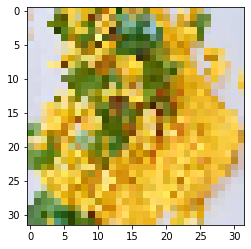

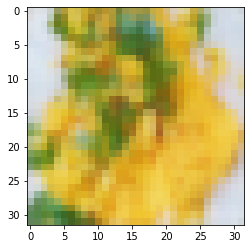

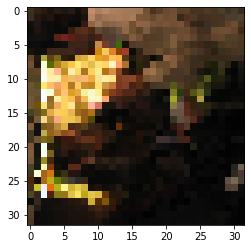

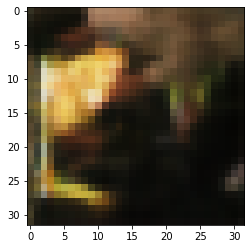

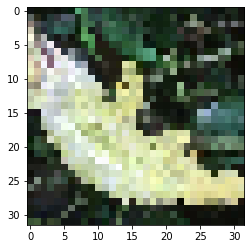

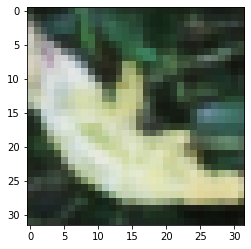

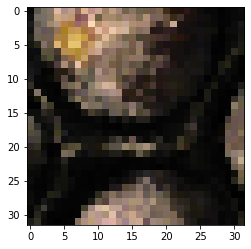

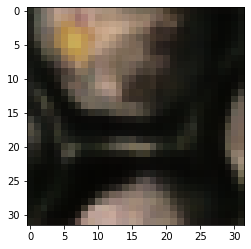

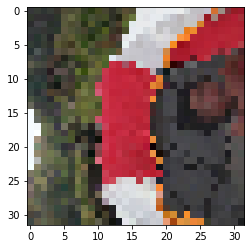

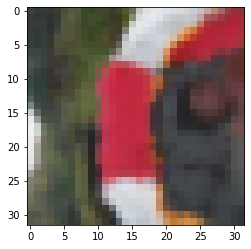

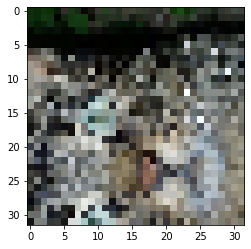

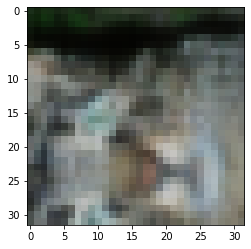

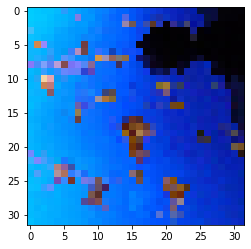

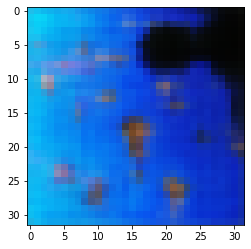

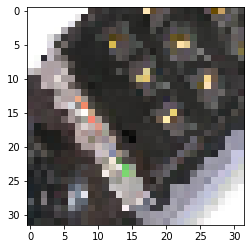

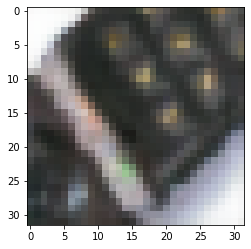

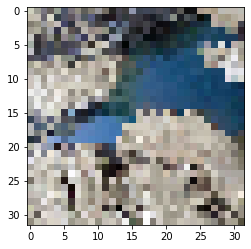

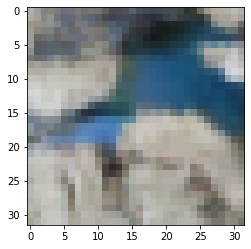

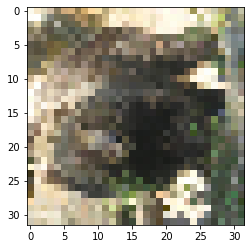

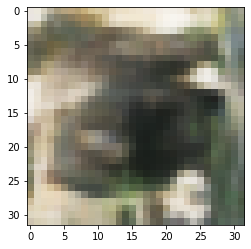

In [19]:
imgs = noisy_imgs_test.narrow(0, 16, mini_batch_size)
imgs2 = clean_images.narrow(0, 16, mini_batch_size)

results = model(imgs).cpu().detach().numpy()


for i in range(10):
  plt.imshow(imgs[i].cpu().T)
  plt.show()

  plt.imshow(results[i].T)
  plt.show()

# Dumb model

In [40]:
# https://github.com/rishikksh20/ResUnet

class ConvRes(nn.Module):
    def __init__(self):
        super(ConvRes, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding = 1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding = 1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding = 1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding = 1)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding = 1)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding = 1)
        self.conv7 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding = 1)
        self.conv8 = nn.Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding = 1)


    def forward(self, x):
      x = nn.ReLU()(self.conv1(x))
      x = nn.ReLU()(self.conv2(x))
      x = nn.ReLU()(self.conv3(x))
      x = nn.ReLU()(self.conv4(x))
      x = nn.ReLU()(self.conv5(x))
      x = nn.ReLU()(self.conv6(x))
      x = nn.ReLU()(self.conv7(x))
      x = self.conv8(x)
      return x



model = ConvRes().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
summary(model, (3, 32, 32))

img = torch.ones(1, 3, 32, 32).to(device)
convres = ConvRes().to(device)
print(convres(img).size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,248
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 32, 32]           9,248
       BatchNorm2d-8           [-1, 32, 32, 32]              64
            Conv2d-9           [-1, 32, 32, 32]           9,248
      BatchNorm2d-10           [-1, 32, 32, 32]              64
           Conv2d-11           [-1, 32, 32, 32]           9,248
      BatchNorm2d-12           [-1, 32, 32, 32]              64
           Conv2d-13           [-1, 32, 32, 32]           9,248
      BatchNorm2d-14           [-1, 32,

In [41]:
nb_epochs = 10
mini_batch_size = 100
start = time.time()


for e in range(nb_epochs):
    train_loss = []
    for b in range(0, noisy_imgs_1.size(0), mini_batch_size):
        output = model(noisy_imgs_1.narrow(0, b, mini_batch_size))
        loss = criterion(output, noisy_imgs_2.narrow(0, b, mini_batch_size))
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch", e + 1, "Train loss:", np.mean(train_loss))

    # Test the model
    with torch.no_grad():
      test_results = model(noisy_imgs_test)
      print("Test loss: ", criterion(test_results, clean_images).cpu().numpy())
      print("---")


end = time.time()
print((end - start) / 60.0)

Epoch 1 Train loss: 0.034874496614560484
Test loss:  0.005751016
---
Epoch 2 Train loss: 0.016788267072290183
Test loss:  0.0049885
---
Epoch 3 Train loss: 0.016237424299120902
Test loss:  0.0047612786
---
Epoch 4 Train loss: 0.01595774900354445
Test loss:  0.0046168603
---
Epoch 5 Train loss: 0.015787174200639128
Test loss:  0.0044764983
---
Epoch 6 Train loss: 0.01566748481057584
Test loss:  0.0043749553
---
Epoch 7 Train loss: 0.015571123072877526
Test loss:  0.004304244
---
Epoch 8 Train loss: 0.01548315730318427
Test loss:  0.0042285416
---
Epoch 9 Train loss: 0.015414820974692703
Test loss:  0.004196233
---
Epoch 10 Train loss: 0.015363766323775053
Test loss:  0.004185581
---
10.175948409239451


In [42]:
def psnr( denoised , ground_truth ) :
  # Peak Signal to Noise Ratio : denoised and ground˙truth have range [0 , 1]
  mse = torch.mean(( denoised - ground_truth ) ** 2)
  return -10 * torch.log10( mse + 10**-8)


results = model(noisy_imgs_test)

print(psnr(results, clean_images))

tensor(23.7824, device='cuda:0', grad_fn=<MulBackward0>)


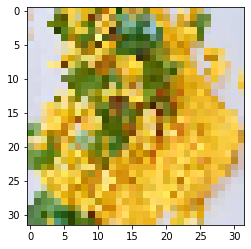

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


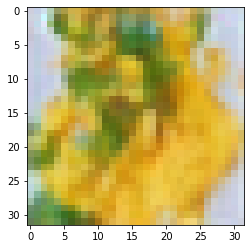

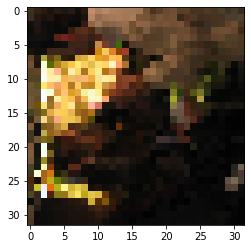

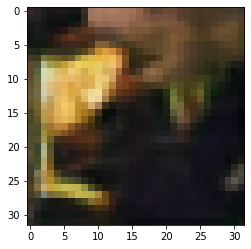

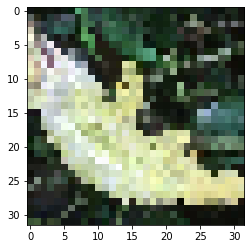

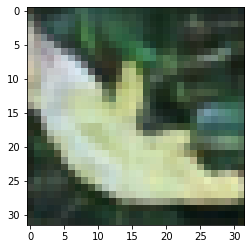

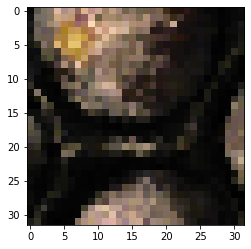

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


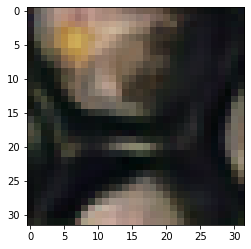

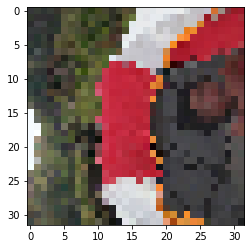

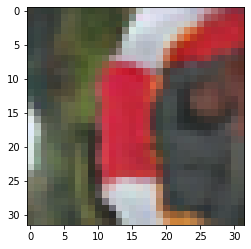

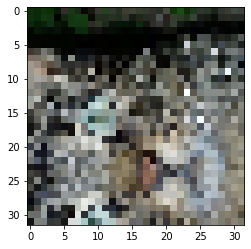

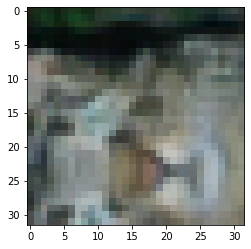

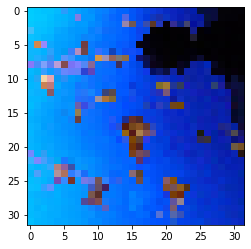

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


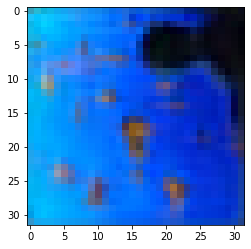

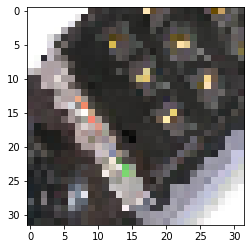

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


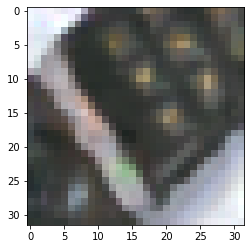

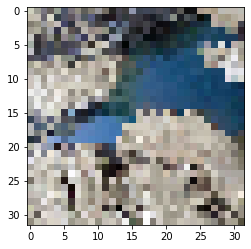

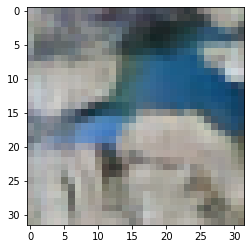

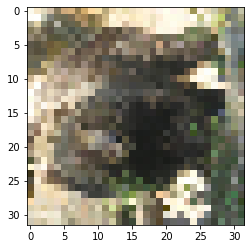

In [ ]:
imgs = noisy_imgs_test.narrow(0, 16, mini_batch_size)
imgs2 = clean_images.narrow(0, 16, mini_batch_size)

results = model(imgs).cpu().detach().numpy()


for i in range(10):
  plt.imshow(imgs[i].cpu().T)
  plt.show()

  plt.imshow(results[i].T)
  plt.show()

# Second UNET

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, strides=1):
        super(ConvBlock, self).__init__()
        self.strides = strides
        self.in_channel=in_channel
        self.out_channel=out_channel
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=strides, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=strides, padding=1),
            nn.LeakyReLU(inplace=True),
        )
        self.conv11 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=strides, padding=0)

    def forward(self, x):
        out1 = self.block(x)
        out2 = self.conv11(x)
        out = out1 + out2
        return out

class UNet2(nn.Module):
    def __init__(self, block=ConvBlock,dim=32):
        super(UNet2, self).__init__()

        self.dim = dim
        self.ConvBlock1 = ConvBlock(3, dim, strides=1)
        self.pool1 = nn.Conv2d(dim,dim,kernel_size=4, stride=2, padding=1)

        self.ConvBlock2 = block(dim, dim*2, strides=1)
        self.pool2 = nn.Conv2d(dim*2,dim*2,kernel_size=4, stride=2, padding=1)
       
        self.ConvBlock3 = block(dim*2, dim*4, strides=1)
        self.pool3 = nn.Conv2d(dim*4,dim*4,kernel_size=4, stride=2, padding=1)
       
        self.ConvBlock4 = block(dim*4, dim*8, strides=1)
        self.pool4 = nn.Conv2d(dim*8, dim*8,kernel_size=4, stride=2, padding=1)

        self.ConvBlock5 = block(dim*8, dim*16, strides=1)

        self.upv6 = nn.ConvTranspose2d(dim*16, dim*8, 2, stride=2)
        self.ConvBlock6 = block(dim*16, dim*8, strides=1)

        self.upv7 = nn.ConvTranspose2d(dim*8, dim*4, 2, stride=2)
        self.ConvBlock7 = block(dim*8, dim*4, strides=1)

        self.upv8 = nn.ConvTranspose2d(dim*4, dim*2, 2, stride=2)
        self.ConvBlock8 = block(dim*4, dim*2, strides=1)

        self.upv9 = nn.ConvTranspose2d(dim*2, dim, 2, stride=2)
        self.ConvBlock9 = block(dim*2, dim, strides=1)

        self.conv10 = nn.Conv2d(dim, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        conv1 = self.ConvBlock1(x)
        pool1 = self.pool1(conv1)

        conv2 = self.ConvBlock2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.ConvBlock3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.ConvBlock4(pool3)
        pool4 = self.pool4(conv4)

        conv5 = self.ConvBlock5(pool4)

        up6 = self.upv6(conv5)
        up6 = torch.cat([up6, conv4], 1)
        conv6 = self.ConvBlock6(up6)

        up7 = self.upv7(conv6)
        up7 = torch.cat([up7, conv3], 1)
        conv7 = self.ConvBlock7(up7)

        up8 = self.upv8(conv7)
        up8 = torch.cat([up8, conv2], 1)
        conv8 = self.ConvBlock8(up8)

        up9 = self.upv9(conv8)
        up9 = torch.cat([up9, conv1], 1)
        conv9 = self.ConvBlock9(up9)

        conv10 = self.conv10(conv9)
        out = x + conv10
        return conv10

In [15]:
model = UNet2().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
summary(model, (3, 32, 32))

img = torch.ones(1, 3, 32, 32).to(device)
convres = UNet2().to(device)
print(convres(img).size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         LeakyReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
         LeakyReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             128
         ConvBlock-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 16, 16]          16,416
            Conv2d-8           [-1, 64, 16, 16]          18,496
         LeakyReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
        LeakyReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]           2,112
        ConvBlock-13           [-1, 64, 16, 16]               0
           Conv2d-14             [-1, 6

In [16]:
# training

nb_epochs = 10
mini_batch_size = 100
start = time.time()

for e in range(nb_epochs):
    train_loss = []
    for b in range(0, noisy_imgs_1.size(0), mini_batch_size):
        output = model(noisy_imgs_1.narrow(0, b, mini_batch_size))
        loss = criterion(output, noisy_imgs_2.narrow(0, b, mini_batch_size))
        train_loss.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch", e + 1, "Train loss:", np.mean(train_loss))

    # Test the model
    with torch.no_grad():
      test_results = model(noisy_imgs_test)
      print("Test loss: ", criterion(test_results, clean_images).cpu().numpy())
      print("---")


end = time.time()
print((end - start) / 60.0) # prints how long training took, in minutes

Epoch 1 Train loss: 0.033167087
Test loss:  0.004411796
---
Epoch 2 Train loss: 0.015096788
Test loss:  0.0041815573
---
Epoch 3 Train loss: 0.014959054
Test loss:  0.0041048597
---
Epoch 4 Train loss: 0.014869453
Test loss:  0.003982985
---
Epoch 5 Train loss: 0.014804615
Test loss:  0.0038898408
---
Epoch 6 Train loss: 0.014756195
Test loss:  0.0038262084
---
Epoch 7 Train loss: 0.014715311
Test loss:  0.0037960466
---
Epoch 8 Train loss: 0.014678438
Test loss:  0.0037661155
---
Epoch 9 Train loss: 0.014646381
Test loss:  0.003720937
---
Epoch 10 Train loss: 0.014616952
Test loss:  0.0036910737
---
25.186931280295052


In [17]:
def psnr( denoised , ground_truth ) :
  # Peak Signal to Noise Ratio : denoised and ground˙truth have range [0 , 1]
  mse = torch.mean(( denoised - ground_truth ) ** 2)
  return -10 * torch.log10( mse + 10**-8)


results = model(noisy_imgs_test)

print(psnr(results, clean_images))

tensor(24.3285, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
!kill $(ps aux | awk '{print $2}')